In [113]:
import pandas as pd
import numpy as np
import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import re
import matplotlib.pyplot as plt
from tqdm import tqdm
import nltk
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.metrics import confusion_matrix

nltk.download('punkt')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tymon\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
globalDataPath = 'Data/datasets_full.csv/'
userDataFolders = ['genuine_accounts.csv']
botDataFolders = ['social_spambots_1.csv', 'social_spambots_2.csv', 'social_spambots_3.csv']#, 'traditional_spambots_1.csv']#, 'traditional_spambots_2.csv', 'traditional_spambots_3.csv', 'traditional_spambots_4.csv']

class Data:
    def __init__(self, dataFolders):
        tweets, users = self.readDataFolders(dataFolders)
        self.tweets = tweets
        self.users = users
        
    def readDataFolders(self, dataFolders):
        tweets = pd.DataFrame()
        users = pd.DataFrame()
        for folder in dataFolders:
            tweets = tweets.append(pd.read_csv(globalDataPath + folder + '/tweets.csv', encoding='utf-8', on_bad_lines='skip'))
            users = users.append(pd.read_csv(globalDataPath + folder + '/users.csv', encoding='utf-8', on_bad_lines='skip'))
        return tweets, users

desired_header = ["id", "text", "source", "user_id", "truncated", "in_reply_to_status_id", "in_reply_to_user_id", 
                  "in_reply_to_screen_name", "retweeted_status_id", "geo", "unknown", "place", "contributors", "retweet_count", 
                  "reply_count", "favorite_count", "favorited", "retweeted", "possibly_sensitive", "num_hashtags", 
                  "num_urls", "num_mentions", "created_at", "timestamp", "crawled_at", "updated"]


userData = Data(userDataFolders)
userData.tweets.columns = desired_header
botData = Data(botDataFolders)

aggregate_tweets = pd.concat([userData.tweets, botData.tweets], ignore_index=True)
aggregate_users = pd.concat([userData.users, botData.users], ignore_index=True)

aggregateData = Data([])
aggregateData.tweets = aggregate_tweets
aggregateData.users = aggregate_users


C:\Users\tymon\AppData\Local\Temp\ipykernel_8512\2001406191.py:15: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,16,17,18,19,20,21,22,23,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  tweets = tweets.append(pd.read_csv(globalDataPath + folder + '/tweets.csv', encoding='utf-8', on_bad_lines='skip'))
C:\Users\tymon\AppData\Local\Temp\ipykernel_8512\2001406191.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tweets = tweets.append(pd.read_csv(globalDataPath + folder + '/tweets.csv', encoding='utf-8', on_bad_lines='skip'))
C:\Users\tymon\AppData\Local\Temp\ipykernel_8512\2001406191.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  users = users.append(pd.read_csv(globalDataPath + folder + '/users.csv', encoding='utf-8', on_bad_lines='skip'))
C:\Users\tymon\AppData

In [ ]:
user_tweets_path = 'Data/datasets_full.csv/genuine_accounts.csv/tweets.csv'
social_bot_tweets_path = 'Data/datasets_full.csv/social_spambots_1.csv/tweets.csv'

desired_header = ["id", "text", "source", "user_id", "truncated", "in_reply_to_status_id", "in_reply_to_user_id", 
                  "in_reply_to_screen_name", "retweeted_status_id", "geo", "unknown", "place", "contributors", "retweet_count", 
                  "reply_count", "favorite_count", "favorited", "retweeted", "possibly_sensitive", "num_hashtags", 
                  "num_urls", "num_mentions", "created_at", "timestamp", "crawled_at", "updated"]

# user_first_row = pd.read_csv(user_tweets_path, nrows=1, header=None)
# print("First row of the user tweets CSV file:")
# print(user_first_row)

# print("Number of columns in the first row:", user_first_row.shape[1])
# print("Number of columns in the desired header:", len(desired_header))

user_tweets_df = pd.read_csv(user_tweets_path, names=desired_header, on_bad_lines='skip', index_col=False)

print("First row of user tweets with the header applied:")
print(user_tweets_df.head(1).transpose())

# social_bot_first_row = pd.read_csv(social_bot_tweets_path, nrows=1, header=None)
# print("First row of the social bot tweets CSV file:")
# print(social_bot_first_row)

social_bot_tweets_df = pd.read_csv(social_bot_tweets_path, encoding='utf-8', on_bad_lines='skip', index_col=False)

print("First row of social bot tweets with the header applied:")
print(social_bot_tweets_df.head(1).transpose())

C:\Users\tymon\AppData\Local\Temp\ipykernel_8512\3929463313.py:21: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,16,17,18,19,20,21,22,23,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  user_tweets_df = pd.read_csv(user_tweets_path, names=desired_header, on_bad_lines='skip', index_col=False)


First row of user tweets with the header applied:
                                                                         0
id                                                      593932392663912449
text                     RT @morningJewshow: Speaking about Jews and co...
source                   <a href=\http://tapbots.com/tweetbot\" rel=\"n...
user_id                                                             678033
truncated                                                              NaN
in_reply_to_status_id                                                  0.0
in_reply_to_user_id                                                      0
in_reply_to_screen_name                                                NaN
retweeted_status_id                                     593932168524533760
geo                                                                     \N
unknown                                                                 \N
place                                             

C:\Users\tymon\AppData\Local\Temp\ipykernel_8512\3929463313.py:33: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  social_bot_tweets_df = pd.read_csv(social_bot_tweets_path, encoding='utf-8', on_bad_lines='skip', index_col=False)


First row of social bot tweets with the header applied:
                                                                         0
id                                                      532627591686275072
text                      I Pooh - In silenzio 1968 http://t.co/ahvQxUqTws
source                   <a href="http://www.facebook.com/twitter" rel=...
user_id                                                           24858289
truncated                                                              NaN
in_reply_to_status_id                                                    0
in_reply_to_user_id                                                      0
in_reply_to_screen_name                                                NaN
retweeted_status_id                                                      0
geo                                                                    NaN
place                                                                  NaN
contributors                                

## Feature engineering

In [ ]:
def extract_user_features(users_df):
    now = pd.to_datetime('now').tz_localize(None)
    users_df['created_at'] = pd.to_datetime(users_df['created_at']).dt.tz_localize(None)
    users_df['account_age'] = now - users_df['created_at']
    users_df['account_age'] = users_df['account_age'].dt.days
    users_df = users_df.rename  (columns={'id': 'user_id'})
    return users_df[['user_id', 'account_age', 'location', 'lang']]

user_features = extract_user_features(userData.users)
print(user_features)
bot_features = extract_user_features(botData.users)
print(bot_features)


         user_id  account_age                   location lang
0     1502026416         4205             Tokyo .Japan .   ja
1     2492782375         3869                    神奈川県横浜市   ja
2      293212315         4973                        NaN   en
3      191839658         5203  #freePalestine - rip paul   en
4     3020965143         3600                 Wichita KS   en
...          ...          ...                        ...  ...
3469   205218909         5170             madrid, españa   es
3470  2874966164         3705       Islamabad , Pakistan   en
3471  2980901837         3621                  Islamabad   en
3472   121122678         5396                     Serbia   en
3473  2910276853         3673                        NaN   en

[3474 rows x 4 columns]
        user_id  account_age                    location lang
0      24858289         5752                         NaN   it
1      33212890         5719                       Italy   it
2      39773427         5695  iPhone: 45.4716

C:\Users\tymon\AppData\Local\Temp\ipykernel_8512\4084433490.py:2: FutureWarning: The parsing of 'now' in pd.to_datetime without `utc=True` is deprecated. In a future version, this will match Timestamp('now') and Timestamp.now()
  now = pd.to_datetime('now').tz_localize(None)  # Ensure 'now' is timezone-naive
C:\Users\tymon\AppData\Local\Temp\ipykernel_8512\4084433490.py:2: FutureWarning: The parsing of 'now' in pd.to_datetime without `utc=True` is deprecated. In a future version, this will match Timestamp('now') and Timestamp.now()
  now = pd.to_datetime('now').tz_localize(None)  # Ensure 'now' is timezone-naive


In [ ]:
def extract_temporal_features(tweets_df):
    tweets_df['timestamp'] = pd.to_datetime(tweets_df['timestamp'])
    tweets_df['user_id'] = pd.to_numeric(tweets_df['user_id'], errors='coerce')
    tweets_df = tweets_df.dropna(subset=['user_id'])
    tweets_df['user_id'] = tweets_df['user_id'].astype(str)
    tweets_df = tweets_df.sort_values(by=['user_id', 'timestamp'])
    tweets_df['time_diff'] = tweets_df.groupby('user_id')['timestamp'].diff().fillna(pd.Timedelta(seconds=0))
    tweet_rate = tweets_df.groupby('user_id')['time_diff'].mean()
    return tweet_rate

user_temporal = extract_temporal_features(userData.tweets)
print(user_temporal)
bot_temporal = extract_temporal_features(botData.tweets)
print(bot_temporal)

C:\Users\tymon\AppData\Local\Temp\ipykernel_8512\2883565944.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_df['user_id'] = tweets_df['user_id'].astype(str)


user_id
0.0            0 days 00:01:51.159685863
1.0                      0 days 00:00:00
100043740.0    0 days 02:56:22.726528040
100120312.0    0 days 00:59:04.722274289
1005131857.0   0 days 00:40:31.158904971
                          ...           
992557464.0    0 days 06:52:42.833878351
99494968.0     0 days 00:41:40.610761485
99716926.0     0 days 06:55:28.471864193
997997443.0    0 days 01:22:52.165252906
999662546.0    0 days 13:41:46.540327868
Name: time_diff, Length: 3455, dtype: timedelta64[ns]
user_id
1002202471   0 days 00:23:48.762732919
1013031680   0 days 00:28:12.917445482
101882667    0 days 13:49:00.043888166
1021573561   0 days 16:38:37.219780219
1022420287   0 days 05:32:09.932823412
                        ...           
96435556     0 days 01:04:45.121973929
970094882    0 days 00:20:11.777230769
974255899    0 days 00:23:50.565584009
981247207    0 days 00:23:37.642945544
982414274    0 days 00:23:35.526461538
Name: time_diff, Length: 4912, dtype: timedelta64[

In [119]:
def extract_network_features(tweets_df):
    G = nx.Graph()
    print(tweets_df.columns)

    username_to_id = dict(zip(aggregateData.users['screen_name'], aggregateData.users['id']))

    for _, tweet in tweets_df.iterrows():
        user_id = tweet['user_id']
        try:
            num_mentions = int(tweet['num_mentions'])
        except (ValueError, TypeError):
            num_mentions = 0

        if num_mentions != 0:
            tweet_text = str(tweet['text'])
            mentions = re.findall(r'@(\w+)', tweet_text)

            for mention in mentions:
                if mention in username_to_id:
                    mention_id = username_to_id[mention]
                    if user_id != mention_id:
                        G.add_edge(user_id, mention_id)
    
    
    degree = dict(G.degree())
    centrality = nx.degree_centrality(G)
    clustering = nx.clustering(G)
    
    network_features = pd.DataFrame({
        'degree': degree,
        'centrality': centrality,
        'clustering_coefficient': clustering
    })
    
    return G, network_features
    
user_network_graph, user_network_features = extract_network_features(userData.tweets)
bot_network_graph, bot_network_features = extract_network_features(botData.tweets)

Index(['id', 'text', 'source', 'user_id', 'truncated', 'in_reply_to_status_id',
       'in_reply_to_user_id', 'in_reply_to_screen_name', 'retweeted_status_id',
       'geo', 'unknown', 'place', 'contributors', 'retweet_count',
       'reply_count', 'favorite_count', 'favorited', 'retweeted',
       'possibly_sensitive', 'num_hashtags', 'num_urls', 'num_mentions',
       'created_at', 'timestamp', 'crawled_at', 'updated'],
      dtype='object')
Index(['id', 'text', 'source', 'user_id', 'truncated', 'in_reply_to_status_id',
       'in_reply_to_user_id', 'in_reply_to_screen_name', 'retweeted_status_id',
       'geo', 'place', 'contributors', 'retweet_count', 'reply_count',
       'favorite_count', 'favorited', 'retweeted', 'possibly_sensitive',
       'num_hashtags', 'num_urls', 'num_mentions', 'created_at', 'timestamp',
       'crawled_at', 'updated'],
      dtype='object')


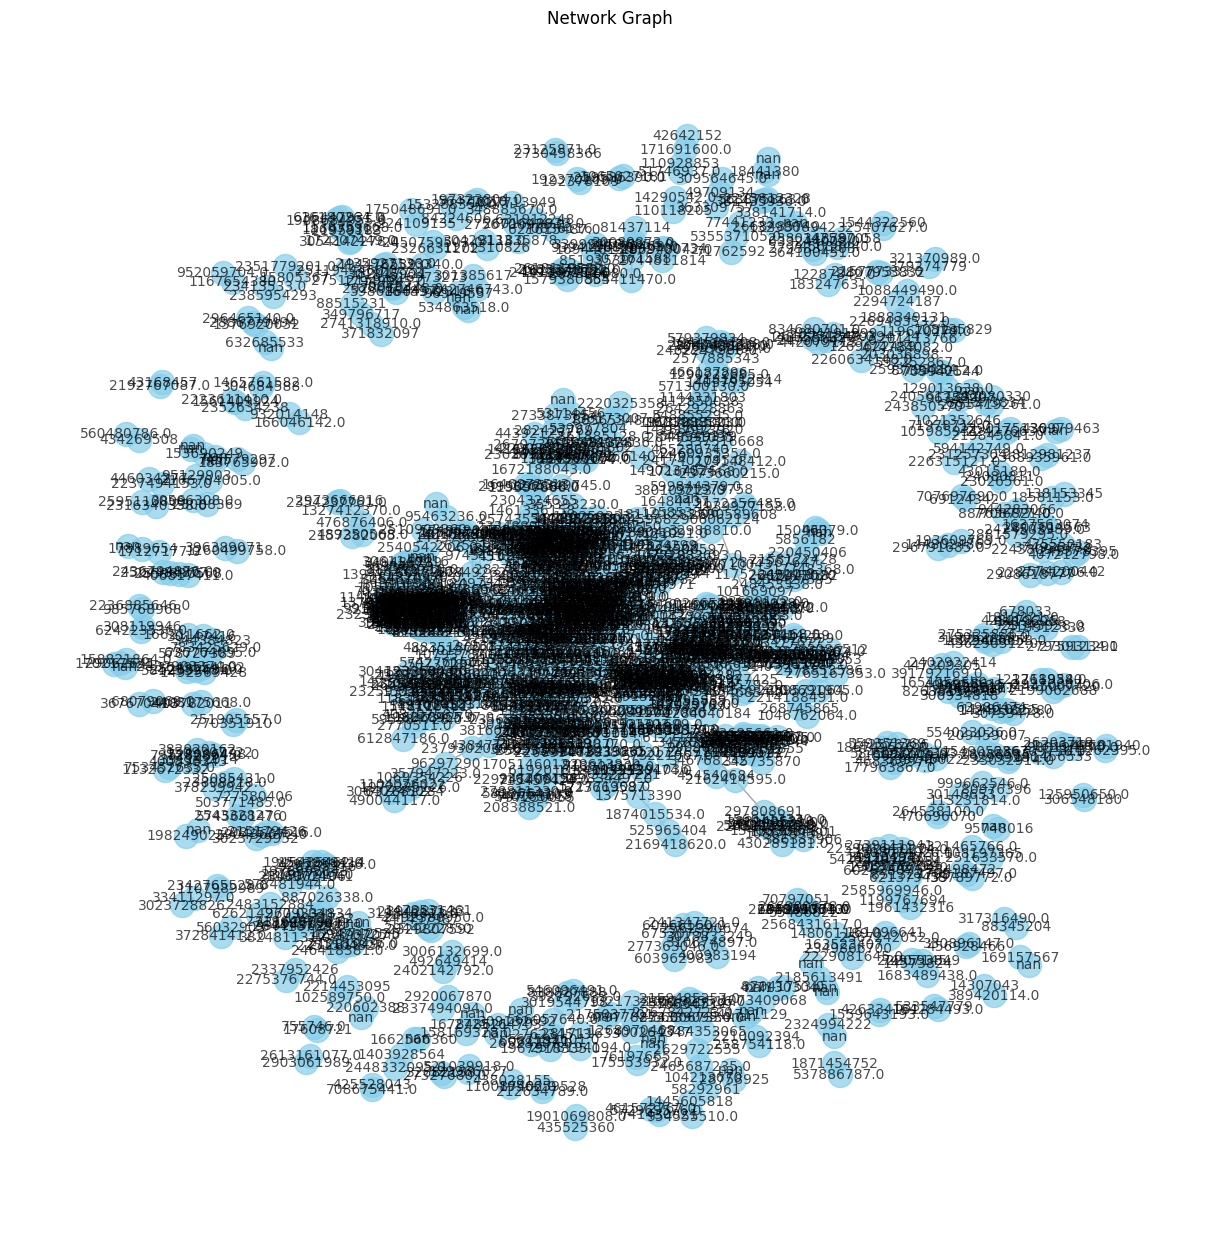

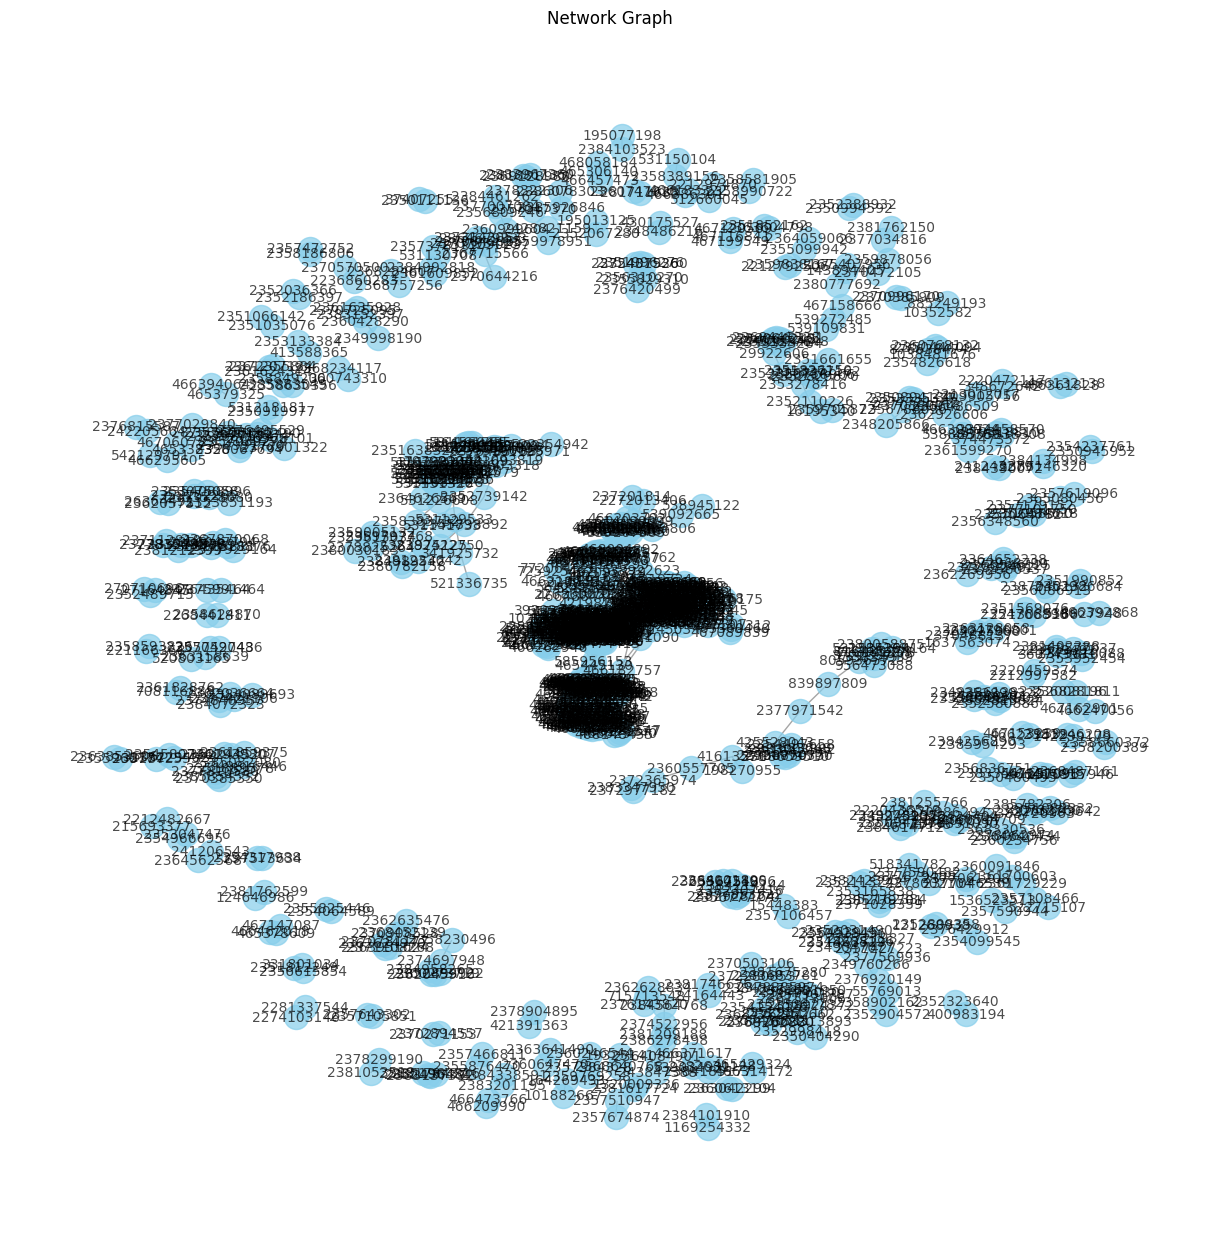

In [120]:
def visualize_graph(G):
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_size=300, node_color='skyblue', font_size=10, font_color='black', edge_color='gray', linewidths=1, alpha=0.7)
    plt.title("Network Graph")
    plt.show()

visualize_graph(user_network_graph)
visualize_graph(bot_network_graph)

In [ ]:
tqdm.pandas(desc="Sentiment Analysis")

def extract_sentiment_features(tweets_df):
    tweets_df['polarity'] = tweets_df['text'].progress_apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    tweets_df['subjectivity'] = tweets_df['text'].progress_apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)
    return tweets_df[['user_id', 'polarity', 'subjectivity']]

user_sentiment = extract_sentiment_features(userData.tweets)
bot_sentiment = extract_sentiment_features(botData.tweets)

Sentiment Analysis: 100%|██████████| 3457133/3457133 [06:25<00:00, 8975.26it/s] 


In [93]:
# print(user_features.head())
# user_temporal = user_temporal.reset_index()
# user_temporal.columns = ['user_id', 'time_diff']
user_temporal['user_id'] = user_temporal['user_id'].astype(int)
print(user_temporal.head())
print(user_temporal.dtypes)
# user_network_features.reset_index(inplace=True).rename(columns={'index': 'user_id'}, inplace=True)
# print(user_network_features.head())
# print(user_sentiment.head())
# print(user_features.dtypes)

# print(bot_features.head())
# bot_temporal = bot_temporal.reset_index()
# bot_temporal.columns = ['user_id', 'time_diff']
bot_temporal['user_id'] = bot_temporal['user_id'].astype(int)
print(bot_temporal)
print(bot_temporal.dtypes)
# bot_network_features.reset_index(inplace=True)
# bot_network_features.rename(columns={'index': 'user_id'}, inplace=True)
# print(bot_network_features.head())
# print(bot_sentiment.head())

      user_id                 time_diff
0           0 0 days 00:01:51.159685863
1           1           0 days 00:00:00
2   100043740 0 days 02:56:22.726528040
3   100120312 0 days 00:59:04.722274289
4  1005131857 0 days 00:40:31.158904971
user_id                int32
time_diff    timedelta64[ns]
dtype: object
         user_id                 time_diff
0     1002202471 0 days 00:23:48.762732919
1     1013031680 0 days 00:28:12.917445482
2      101882667 0 days 13:49:00.043888166
3     1021573561 0 days 16:38:37.219780219
4     1022420287 0 days 05:32:09.932823412
...          ...                       ...
4907    96435556 0 days 01:04:45.121973929
4908   970094882 0 days 00:20:11.777230769
4909   974255899 0 days 00:23:50.565584009
4910   981247207 0 days 00:23:37.642945544
4911   982414274 0 days 00:23:35.526461538

[4912 rows x 2 columns]
user_id                int32
time_diff    timedelta64[ns]
dtype: object


In [ ]:
def combine_features(user_features, temporal_features, network_features, sentiment_features):
    # combined = user_features.merge(temporal_features, on='user_id', how='left').fillna(0)
    combined = user_features.merge(network_features, on='user_id', how='left').fillna(0)
    combined = combined.merge(sentiment_features, on='user_id', how='left').fillna(0)
    return combined

user_combined = combine_features(user_features, user_temporal, user_network_features, user_sentiment)
bot_combined = combine_features(bot_features, bot_temporal, bot_network_features, bot_sentiment)
user_combined['label'] = 0
bot_combined['label'] = 1
full_dataset = pd.concat([user_combined, bot_combined], ignore_index=True)

In [96]:
print(full_dataset.head())

      user_id  account_age        location lang  degree  centrality  \
0  1502026416         4205  Tokyo .Japan .   ja     2.0    0.000631   
1  1502026416         4205  Tokyo .Japan .   ja     2.0    0.000631   
2  1502026416         4205  Tokyo .Japan .   ja     2.0    0.000631   
3  1502026416         4205  Tokyo .Japan .   ja     2.0    0.000631   
4  1502026416         4205  Tokyo .Japan .   ja     2.0    0.000631   

   clustering_coefficient  polarity  subjectivity  label  
0                     0.0       0.0           0.0      0  
1                     0.0       0.0           0.0      0  
2                     0.0       0.0           0.0      0  
3                     0.0       0.0           0.0      0  
4                     0.0       0.0           0.0      0  


## Training

In [ ]:
full_dataset = full_dataset.drop_duplicates(subset=['user_id'])

full_dataset['location'] = full_dataset['location'].fillna('unknown')
full_dataset['lang'] = full_dataset['lang'].fillna('unknown')

numeric_cols = ['account_age', 'degree', 'centrality', 'clustering_coefficient', 'polarity', 'subjectivity']
full_dataset[numeric_cols] = full_dataset[numeric_cols].fillna(full_dataset[numeric_cols].median())

full_dataset['location'] = full_dataset['location'].astype(str)

label_encoders = {}
for col in ['location', 'lang']:
    le = LabelEncoder()
    full_dataset[col] = le.fit_transform(full_dataset[col])
    label_encoders[col] = le 

X = full_dataset.drop('label', axis=1)
y = full_dataset['label']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)



In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)
y_pred_prob = rf_classifier.predict_proba(X_test)[:, 1]

print("Classification Report:")
# print(classification_report(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_pred_prob))

Classification Report:
AUC Score: 0.997405074038114


[[702  15]
 [ 11 950]]


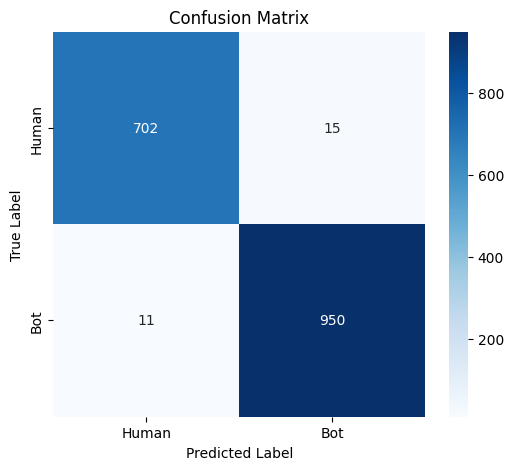

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
labels = ['Human', 'Bot']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

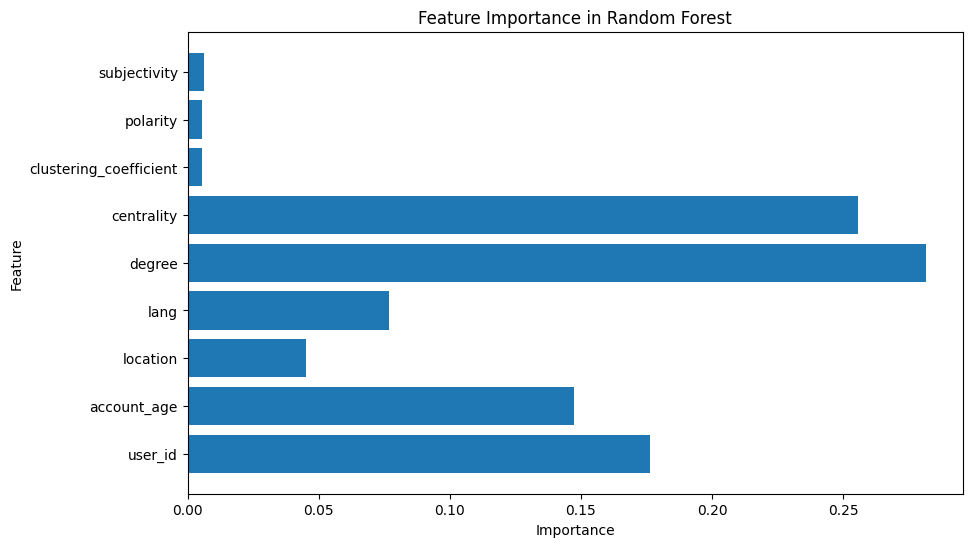

In [118]:
feature_importances = rf_classifier.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(X.columns, feature_importances)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest')
plt.show()